In [2]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
from shallowwater import (ModelParams, make_grid, setup_initial_state, wind_gyre_forcing,
                          run_model, compute_dt_cfl,animate_eta)
import numpy as np
import matplotlib.pyplot as plt


### Equatorial Kelvin wave via initial condition (no forcing)

In [12]:
# --- Equatorial Kelvin wave: IC launch (no forcing) ---

import numpy as np

# Big equatorial basin
Nx, Ny = 256, 128
Lx, Ly = 8.0e6, 4.0e6     # 8000 km x 4000 km
grid = make_grid(Nx, Ny, Lx, Ly)

# β-plane centered at the equator (f0=0), light damping to suppress IG noise
beta_eq = 2.3e-11         # s^-1 m^-1 (≈ 2Ω/a)
H = 100.0                 # m (barotropic-ish, slower c so you can watch it)
params = ModelParams(H=H, g=9.81, rho=1025.0,
                     f0=0.0, beta=beta_eq, y0=Ly/2,
                     r=1/(10*86400), linear=True)

c = np.sqrt(params.g * params.H)          # gravity wave speed
L_R = np.sqrt(c / params.beta)            # equatorial deformation radius
print(f"c ≈ {c:.1f} m/s,  L_R ≈ {L_R/1e3:.0f} km")

# Time step & duration (~2.5 days lets the Kelvin wave traverse most of the domain)
dt = compute_dt_cfl(grid, params, cfl=0.5)
tmax = 10 * 86400.0

# Initial condition: Kelvin structure (η Gaussian in y around equator, right-moving in x)
def ic_equatorial_kelvin(g, p, A=0.10, x0=0.8e6, sx=3.0e5):
    """
    A: η amplitude [m]
    x0: center in x (m)
    sx: Gaussian width in x (m)
    Meridional structure ~ exp(-y^2/(2 L_R^2)), v=0, u ≈ (c/H) η (Kelvin phase relation)
    """
    X, Y = np.meshgrid(g.x_c, g.y_c)
    y = Y - g.Ly/2.0
    eta = A * np.exp(-0.5 * (y / L_R)**2) * np.exp(-0.5 * ((X - x0) / sx)**2)
    u = (c / p.H) * eta                          # u in phase with η for Kelvin
    # Map u from centers to u-grid with simple copy/edge pad
    u_faces = np.zeros((g.Ny, g.Nx + 1))
    u_faces[:, 1:-1] = 0.5 * (u[:, :-1] + u[:, 1:])
    u_faces[:, 0] = u[:, 0]; u_faces[:, -1] = u[:, -1]
    v = np.zeros((g.Ny + 1, g.Nx))               # v ~ 0 for Kelvin
    return eta, u_faces, v

ic_fn = ic_equatorial_kelvin

# No external forcing (let the IC propagate)
from shallowwater import zero_forcing
forcing_fn = lambda t, g, p: zero_forcing(t, g, p)

# Save often to see the wave packet
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=10, out_vars=("eta","u","v"))

print("Saved steps:", len(out["time"]))


c ≈ 31.3 m/s,  L_R ≈ 1167 km
Saved steps: 174


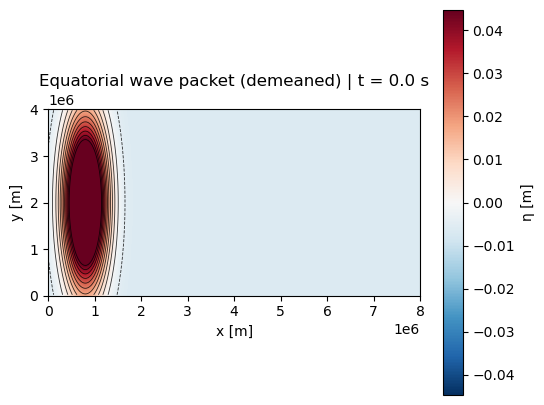

In [13]:
from shallowwater import animate_eta

# Visualize eta(x,y,t) as an animation and display it inline
anim = animate_eta(out, grid, interval=80, contours=True, contour_levels=21,
                   title="Equatorial wave packet (demeaned)")

# GIF (no external dependencies)
anim.save("eta_07.gif", fps=10)


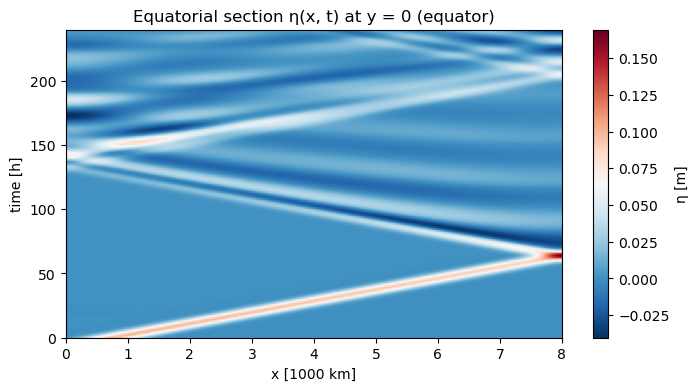

In [14]:
# Simple equatorial Hovmöller: η(x,t) at y=equator
import numpy as np, matplotlib.pyplot as plt
ETA = np.stack(out["eta"])           # (T, Ny, Nx)
jj  = np.argmin(np.abs(grid.y_c - grid.Ly/2))
tt  = np.array(out["time"])/3600.0   # hours
plt.figure(figsize=(8,4))
plt.imshow(ETA[:, jj, :], aspect="auto", origin="lower",
           extent=(0, grid.Lx/1e6, tt[0], tt[-1]), cmap="RdBu_r")
plt.colorbar(label="η [m]")
plt.xlabel("x [1000 km]")
plt.ylabel("time [h]")
plt.title("Equatorial section η(x, t) at y = 0 (equator)")
plt.show()

### Equatorial pulse via Q

In [24]:
# --- Equatorial pulse forcing (starts from rest) ---

import numpy as np

Nx, Ny = 256, 128
Lx, Ly = 8.0e6, 4.0e6
grid = make_grid(Nx, Ny, Lx, Ly)

beta_eq = 2.3e-11
H = 100.0
params = ModelParams(H=H, g=9.81, rho=1025.0,
                     f0=0.0, beta=beta_eq, y0=Ly/2,
                     r=1/(10*86400), linear=True)

dt = compute_dt_cfl(grid, params, cfl=0.5)
tmax = 10.0 * 86400.0

# IC: rest
ic_fn = lambda g, p: setup_initial_state(g, p, mode="rest")

# Short, zero-mean surface mass pulse centered on the equator near the west
def equatorial_pulse_Q(t, g, p,
                       amp=1.0e-7, x0=4e6, sx=2.0e5,
                       sy=3.0e5, t0=6*3600.0, tau=6*3600.0):
    """
    3D Gaussian in (x,y,t); subtract spatial mean so domain mean Q=0.
    """
    X, Y = np.meshgrid(g.x_c, g.y_c)
    y = Y - g.Ly/2.0
    Gxy = np.exp(-0.5*((X-x0)/sx)**2) * np.exp(-0.5*(y/sy)**2)
    Gt  = np.exp(-0.5*((t - t0)/tau)**2)
    Q = amp * Gxy * Gt
    Q -= Q.mean()  # zero spatial mean at each t (no net mass input)
    taux_u = np.zeros((g.Ny, g.Nx + 1))
    tauy_v = np.zeros((g.Ny + 1, g.Nx))
    return taux_u, tauy_v, Q

forcing_fn = lambda t, g, p: equatorial_pulse_Q(t, g, p)

out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=5, out_vars=("eta",))

print("Saved steps:", len(out["time"]))


Saved steps: 347


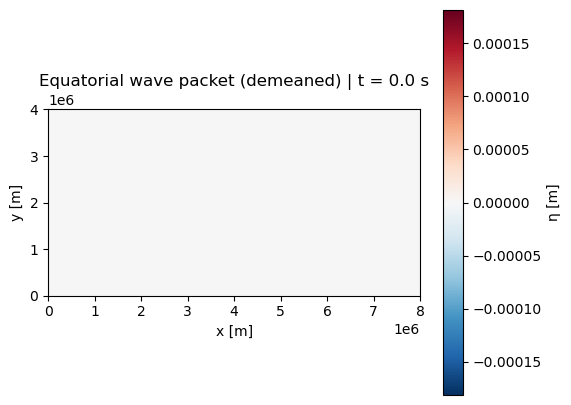

In [25]:
from shallowwater import animate_eta

# Visualize eta(x,y,t) as an animation and display it inline
anim = animate_eta(out, grid, interval=80, contours=True, contour_levels=21,
                   title="Equatorial wave packet (demeaned)")

# GIF (no external dependencies)
anim.save("eta_07b_pulse.gif", fps=10)


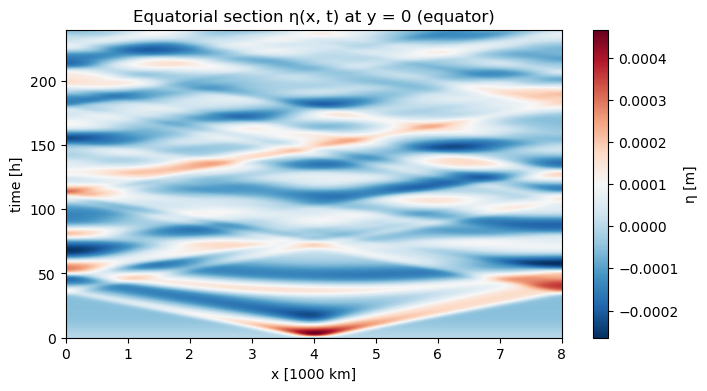

In [26]:
# Simple equatorial Hovmöller: η(x,t) at y=equator
import numpy as np, matplotlib.pyplot as plt
ETA = np.stack(out["eta"])           # (T, Ny, Nx)
jj  = np.argmin(np.abs(grid.y_c - grid.Ly/2))
tt  = np.array(out["time"])/3600.0   # hours
plt.figure(figsize=(8,4))
plt.imshow(ETA[:, jj, :], aspect="auto", origin="lower",
           extent=(0, grid.Lx/1e6, tt[0], tt[-1]), cmap="RdBu_r")
plt.colorbar(label="η [m]")
plt.xlabel("x [1000 km]")
plt.ylabel("time [h]")
plt.title("Equatorial section η(x, t) at y = 0 (equator)")
plt.show()